## Statistics for Documents, Questions, Answers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set_color_codes()
# sns.set_theme()
sns.set_context("paper")

In [3]:
import pandas as pd
import nltk
import numpy as np
import pysbd
from pathlib import Path

from info_salience import utils

In [4]:
seg = pysbd.Segmenter(language="en", clean=False)

In [ ]:
def calculate_stats(dataset):
    # document statistics
    df_docs = pd.read_json(f'../data/processed/{dataset}/documents.json')
    df_docs['n_words'] = df_docs['text'].apply(lambda text: len(text.split()))
    df_docs['n_sents'] = df_docs['text'].apply(lambda text: len(seg.segment(text)))
    doc_stats = {
        'n_docs': len(df_docs),
        'n_words_mean': df_docs['n_words'].mean(),
        'n_words_std': df_docs['n_words'].std(),
        'n_words_min': df_docs['n_words'].min(),
        'n_words_max': df_docs['n_words'].max(),
        'n_sents_mean': df_docs['n_sents'].mean(),
        'n_sents_std': df_docs['n_sents'].std(),
        'n_sents_min': df_docs['n_sents'].min(),
        'n_sents_max': df_docs['n_sents'].max(),
        'n_words_raw': df_docs['n_words'].values
    }

    # discord questions
    f = f'../output/{dataset}/discord_questions.json'
    if Path(f).exists():
        df_discord_questions = pd.read_json(f)
        df_discord_questions = df_discord_questions[df_discord_questions['cluster_id'] != -1]
        df_discord_questions['n_words'] = df_discord_questions['centroid'].apply(lambda text: len(text.split()))
        question_stats = {
            'n_questions': len(df_discord_questions),
            'question_n_words_mean': df_discord_questions['n_words'].mean(),
            'question_n_words_std': df_discord_questions['n_words'].std(),
            'question_n_words_min': df_discord_questions['n_words'].min(),
            'question_n_words_max': df_discord_questions['n_words'].max(),
        }
    else:
        question_stats = {}

    # reference answers
    f = f'../output/{dataset}/discord_answers.json'
    if Path(f).exists():
        df_discord_answers = pd.read_json(f)
        df_discord_answers = df_discord_answers[df_discord_answers['cluster_id'] != -1]
        df_discord_answers['answerable'] = df_discord_answers['reference_answer'] != 'no answer'
        df_discord_answers['n_words'] = df_discord_answers['reference_answer'].apply(lambda text: len(text.split()))
        answer_stats = {
            'answers_per_doc_mean': df_discord_answers.groupby('doc_id')['answerable'].mean().mean(),
            'answers_n_words_mean': df_discord_answers[df_discord_answers['answerable']]['n_words'].mean(),
            'answers_n_words_std': df_discord_answers[df_discord_answers['answerable']]['n_words'].std(),
            'answers_n_words_min': df_discord_answers[df_discord_answers['answerable']]['n_words'].min(),
            'answers_n_words_max': df_discord_answers[df_discord_answers['answerable']]['n_words'].max(),
        }
    else:
        answer_stats = {}


    # answer facts
    f = f'../output/{dataset}/discord_facts.json'
    if Path(f).exists():
        df_discord_facts = pd.read_json(f)
        df_discord_facts = df_discord_facts[df_discord_facts['cluster_id'] != -1]
        question_facts_per_doc = df_discord_facts.groupby('doc_id').size()
        facts_per_answer = df_discord_facts.groupby(['doc_id', 'question']).size()
        answer_facts_stats = {
            'n_question_facts': len(df_discord_facts),
            'question_facts_per_doc_mean': question_facts_per_doc.mean(),
            'question_facts_per_doc_std': question_facts_per_doc.std(),
            'question_facts_per_doc_min': question_facts_per_doc.min(),
            'question_facts_per_doc_max': question_facts_per_doc.max(),
            'facts_per_answer_mean': facts_per_answer.mean(),
            'facts_per_answer_std': facts_per_answer.std(),
            'facts_per_answer_min': facts_per_answer.min(),
            'facts_per_answer_max': facts_per_answer.max(),
        }
    else:
        answer_facts_stats = {}


    return {
        **doc_stats,
        # **fact_stats,
        **question_stats,
        **answer_stats,
        **answer_facts_stats
    }

In [6]:
stats = {}
datasets = ['pubmed-sample', 'cs-cl', 'astro-ph', 'qmsum-generic']
for dataset in datasets:
    stats[dataset] = calculate_stats(dataset)

Summary stats table

In [ ]:
df_stats = pd.DataFrame(stats)
df_stats = df_stats.rename({
    'pubmed-sample': 'PubMed',
    'cs-cl': 'CL',
    'astro-ph': 'Astro',
    'qmsum-generic': 'QMSum'
}, axis=1)
metrics = {
    'n_docs': 'Documents',
    'n_words_mean': 'Words/doc',
    'n_sents_mean': 'Sents/doc',
    'n_questions': 'Questions',
    'answers_per_doc_mean': 'Answered/doc',
    'answers_n_words_mean': 'Words/answer',
    'facts_per_answer_mean': 'Claims/answer',
    'n_question_facts': 'Claims (total)',
}
df_stats = df_stats.loc[metrics.keys()].T
df_stats['answers_per_doc_mean'] = df_stats['answers_per_doc_mean'] * 100

format_mapping = {
    'n_docs': '{}',
    'n_words_mean': '{:,.0f}',
    'n_sents_mean': '{:.1f}',
    'n_questions': '{}',
    'answers_per_doc_mean': '{:.1f}%',
    'answers_n_words_mean': '{:.1f}',
    'n_question_facts': '{:,}',
    'facts_per_answer_mean': '{:.1f}'

}

for key, value in format_mapping.items():
    df_stats[key] = df_stats[key].apply(value.format)

df_stats = df_stats.rename(metrics, axis=1)
df_stats = df_stats.replace('nan.*', '--', regex=True).T
df_stats.index.name = 'Statistic'
df_stats = df_stats.reset_index()
display(df_stats)

tex = df_stats.to_latex(
    index=False,
    position="t",
    caption="TODO",
    label="tab:dataset-statistics",
    na_rep="n/a",
    float_format=lambda x: "{:0.2f}".format(x) if pd.notna(x) else x,
)
for h in df_stats.columns:
    tex = tex.replace(h, "\\textbf{" + h + "}")
print(tex)

,Statistic,PubMed,CL,Astro,QMSum
0,Documents,200,185,106,90
1,Words/doc,290,459,703,"10,837"
2,Sents/doc,16.8,19.9,28.0,1389.6
3,Questions,21,14,13,10
4,Answered/doc,84.1%,86.2%,96.5%,91.9%
5,Words/answer,30.9,53.0,70.3,161.5
6,Claims/answer,6.5,11.4,12.4,29.6
7,Claims (total),"23,124","25,353","16,430","24,459"


\begin{table}[t]
\caption{TODO}
\label{tab:dataset-statistics}
\begin{tabular}{lllll}
\toprule
\textbf{Statistic} & \textbf{PubMed} & \textbf{CL} & \textbf{Astro} & \textbf{QMSum} \\
\midrule
Documents & 200 & 185 & 106 & 90 \\
Words/doc & 290 & 459 & 703 & 10,837 \\
Sents/doc & 16.8 & 19.9 & 28.0 & 1389.6 \\
Questions & 21 & 14 & 13 & 10 \\
Answered/doc & 84.1% & 86.2% & 96.5% & 91.9% \\
Words/answer & 30.9 & 53.0 & 70.3 & 161.5 \\
Claims/answer & 6.5 & 11.4 & 12.4 & 29.6 \\
Claims (total) & 23,124 & 25,353 & 16,430 & 24,459 \\
\bottomrule
\end{tabular}
\end{table}



## Document length

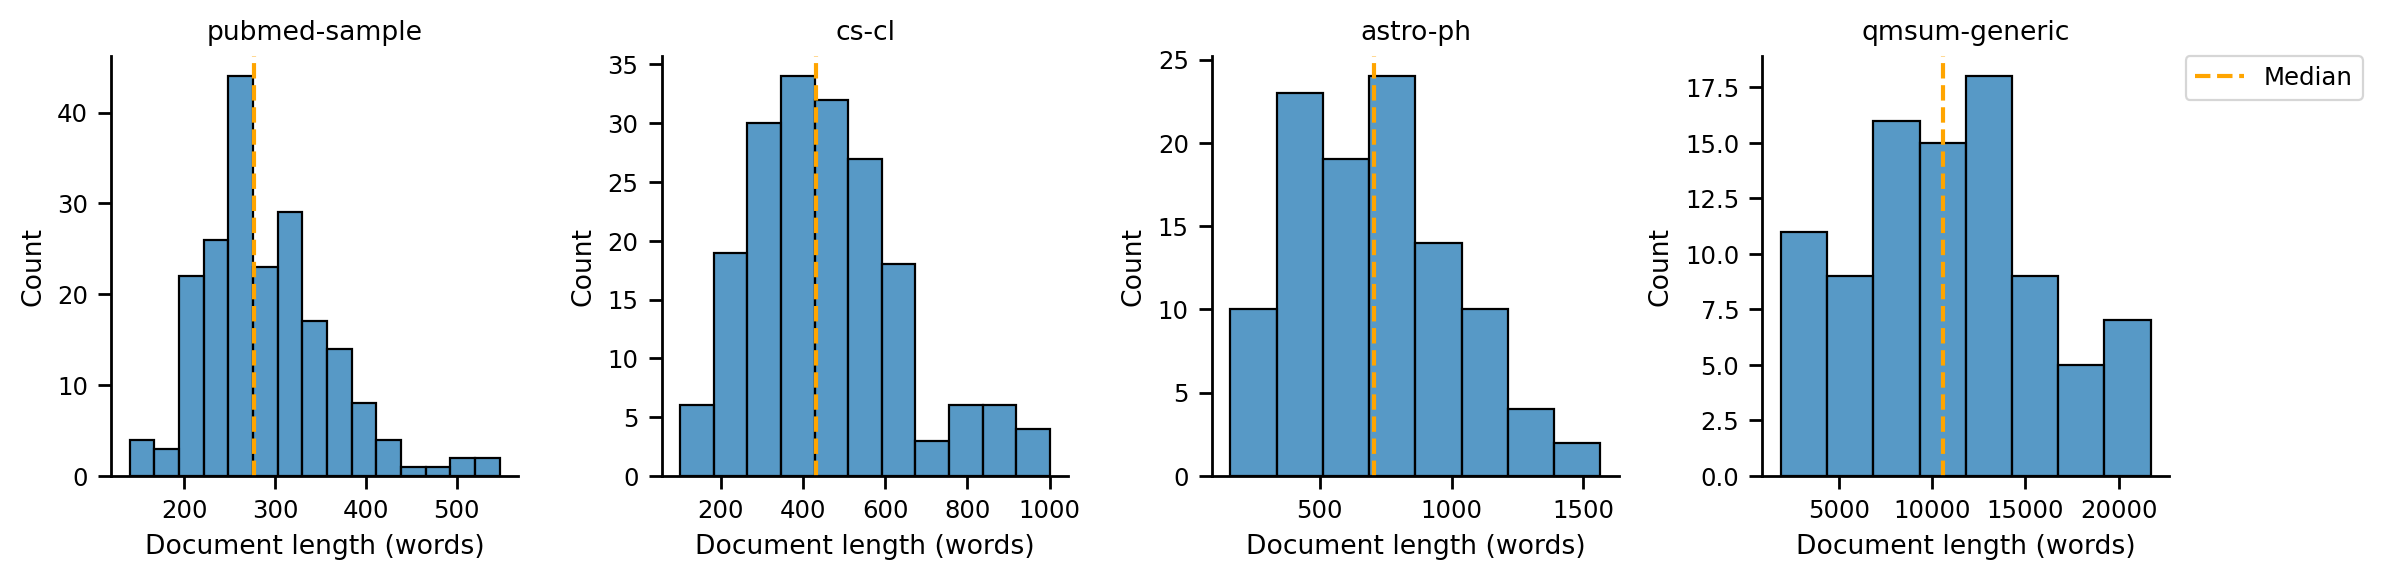

In [ ]:
fig, axes = plt.subplots(1, len(stats), figsize=(12, 3))
for i, (dataset_name, dataset_statistics) in enumerate(stats.items()):
    ax = axes[i]
    data = dataset_statistics['n_words_raw']
    median = np.median(data)

    sns.histplot(data=dataset_statistics['n_words_raw'], ax=ax)
    ax.set_title(dataset_name)
    ax.axvline(x=median, color='orange', linewidth=1.5, linestyle='--', label='Median')
    ax.set_xlabel('Document length (words)')

l1 = plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.tight_layout()
sns.despine()

utils.savefig(fig, "document-lengt", path="../output/figures/", formats=['pdf', 'png', 'svg'])

## Answer length by question

In [9]:
df_questions = pd.read_json('../output/pubmed-sample/discord_questions.json')
df_questions

,cluster_id,centroid,group_id,group_name
0,1,What is the main focus of the study?,1,Topic
1,10,Which patient population is the study concerne...,2,Population
2,9,What condition is being addressed in the study?,3,Population -- Condition
3,18,What is the participant demographic or charact...,4,Population -- demographics
4,36,What was the main intervention used in the study?,5,Intervention
5,31,What are the significant benefits of the inter...,6,Intervention -- benefits
6,6,What are the specific biological markers influ...,7,Intervention -- biomarkers
7,34,What specific treatments were compared in the ...,8,Comparators
8,23,What specific metrics or outcomes were measured?,9,Outcomes
9,28,What are secondary outcomes noted in the study?,10,Outcomes -- Secondary


In [10]:
df_answers = pd.read_json('../output/pubmed-sample/discord_answers.json')
df_answers['reference_answer_length'] = df_answers['reference_answer'].apply(lambda x: len(x.split(' ')))
df_answers = df_answers.groupby('question')['reference_answer_length'].mean()
df_answer_length = df_answers.reset_index()
df_merged = pd.merge(df_questions[['centroid', 'group_id']], df_answer_length, left_on='centroid', right_on='question')[['group_id', 'question', 'reference_answer_length']]
df_merged = df_merged.set_index('group_id')
df_merged


,question,reference_answer_length
group_id,,
1,What is the main focus of the study?,29.015
2,Which patient population is the study concerne...,11.120
3,What condition is being addressed in the study?,8.855
4,What is the participant demographic or charact...,24.550
5,What was the main intervention used in the study?,17.545
6,What are the significant benefits of the inter...,36.040
7,What are the specific biological markers influ...,8.285
8,What specific treatments were compared in the ...,15.920
9,What specific metrics or outcomes were measured?,30.205


## Summaries